## PyTorch Workflow
1. Data (prepare and load)
2. Build model
3. Fitting the model to data (training)
4. Make inference and evaluate model (inference)
5. Saving and Loading the model


In [1]:
# importing libraries
import torch
import pandas as pd
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

## Data preparaing and Loading

In [2]:
# create known parameters
weight = 0.7
bias = 0.3

# create data
X = torch.arange(start=0, end=1, step=0.02).unsqueeze(dim=1)
Y = weight*X + bias
print(X.shape)
print(Y.shape)

torch.Size([50, 1])
torch.Size([50, 1])


## Splitting Data into Train and Test data

In [3]:
# create a train/test split
train = int(0.8 *len(X))
X_train, Y_train = X[:train], Y[:train]
X_test, Y_test = X[train:], Y[train:]

print(len(X_train), len(Y_train), len(X_test), len(Y_test))

40 40 10 10


## Visulaize the input data

In [4]:
def plot_predications (train_data = X_train,
                       train_labels = Y_train,
                       test_data = X_test,
                       test_labels = Y_test,
                       predications = None):
    """
    plotting the training data, test data and compares predications
    """
    plt.figure(figsize=(10,7))
    
    # plot training data 
    plt.scatter(train_data, train_labels, c="b", s=4, label= "Training Data")
    
    # plot testing data
    plt.scatter(test_data, test_labels, c="g", s=4, label = "Testing Data")
    
    if predications is not None:
        # plot the predications
        plt.scatter(test_data, predications, c="r", s=4, label = "Predications")
    
    # show legends
    plt.legend(prop={"size": 14})
    

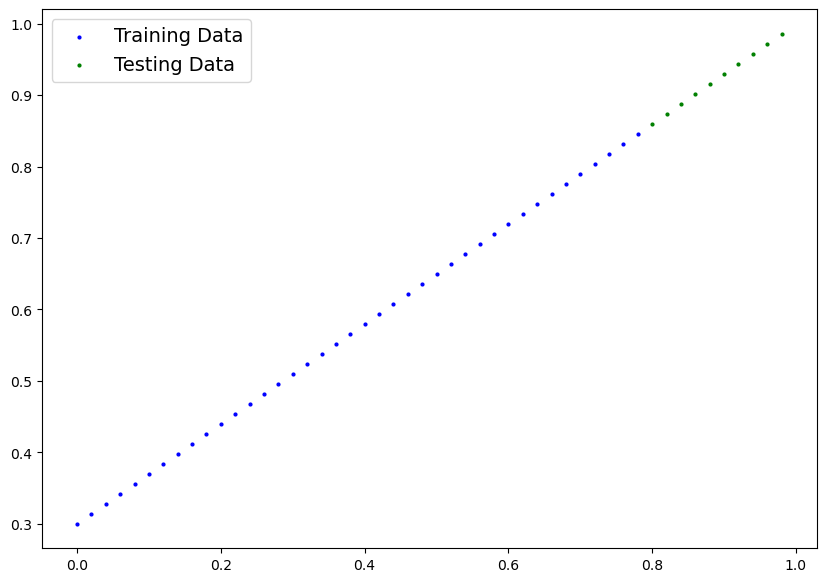

In [5]:
plot_predications()

## Build Model
*  **Linear Regression Model**
*  `documentation:`https://pytorch.org/docs/stable/nn.html

In [6]:
# create a linear regression model class
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        
        # initialize the model parameters
        self.weights = nn.Parameter(torch.rand(1,                           # start with random value
                                               requires_grad = True,        # to optimize this parameter using gradient method algo
                                               dtype = torch.float32))
        
        self.bias = nn.Parameter(torch.rand(1,
                                            requires_grad = True,
                                            dtype = torch.float32))
        
        ## override the forward method
        ## forward method to define the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights*x + self.bias

### PyTorch Model building essentials
*  **`torch.nn`**: contains all the buildings for computational graphs
*  **`torch.nn.Parameter`**: what parameters should our model try and learn 
*  **`torch.nn.Module`** : base class for all neural network modules
*  **`torch.optim`** : this will help to implement optimization algo : gradient descent, to learn parameters
*  **`def forward()`** : all nn.Module subclasses require to overwrite the forward method of the class
*  **`documentation`** : **PyTorch Cheat Sheet**: https://pytorch.org/tutorials/beginner/ptcheat.html

In [7]:
## checking the content of PyTorch model
# create a random seed
torch.manual_seed(42)

# create an instance of the model
model = LinearRegression()
list(model.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [8]:
# list named parameters
model.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [9]:
y_preds = model(X_test)
y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]], grad_fn=<AddBackward0>)

* **torch.no_grad()**
* **torch.inference_mode()** : faster in computation than torch.no_grad

In [10]:
## making predications using 'torch.inference_mode() ---> turn off the track on the gradient value automatically
with torch.inference_mode():                          # with usinh using our output does not have grad_fn attached with it
    y_preds = model(X_test)

"""
with torch.no_grad():
    y_preds = model(X_test)

"""

'\nwith torch.no_grad():\n    y_preds = model(X_test)\n\n'

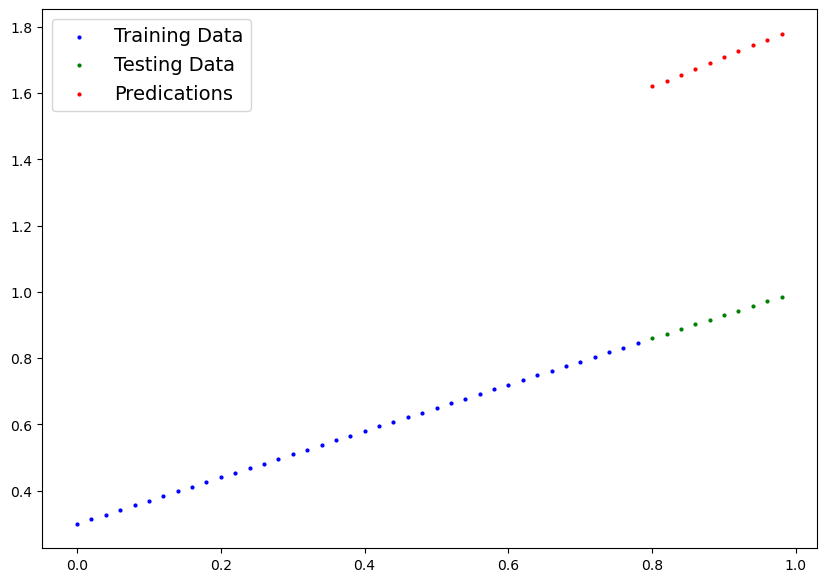

In [11]:
# predications are extremely far away
plot_predications(predications=y_preds)

## Train Model
* **one way to measure how poor the predication are `loss function/cost funtion`**
* **`Loss Function`**: measure the model's predication w.r.t to ideal output value
* **`optimizer`** : takes the loss function as input and adjust's the model parameters (eg weight and biases)

**`Need a Training and Testing Loop in PyTorch to update parameters`**

In [12]:
model.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [13]:
# setup the loss function
loss_fnx = nn.L1Loss()

# setup the optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr= 0.1)

### Building a training loop
1. **Loop through data**
2. **Forward pass** : gives the predication value for given input data
3. **Calculate the loss** : compare forward predication to ground truth labels
4. **Optmizer zero grad**
5. **Loss backwards** : move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss 
6. **Optimizer Step** : gradient descent


In [14]:
epochs  = 1 # loop through the data
for epoch in range(epochs):
    # set the model to training mode -- means sets all parameters that requires grad to require gradient
    model.train()
    
    # forward pass to calculate y_preds
    y_pred = model(X_train)
    
    # calculate the loss 
    loss = loss_fnx(y_pred, Y_train)
    print(f"Loss: {loss}")    
    # optmizer zero grad  --> since optmizer will accumulate the grad thorugh the loop, hence we need to make it zero before next iter
    optimizer.zero_grad()
    
    # perform backpropagation on the loss w.r.t to parameters of the model
    loss.backward()
    
    # perform gradient descent step
    optimizer.step()
    
    # turn-off the gradient tracking in case of model testing
    model.eval()
    
    # print out model state_dict()
    print(model.state_dict())

Loss: 0.6860889196395874
OrderedDict([('weights', tensor([0.8433])), ('bias', tensor([0.8150]))])


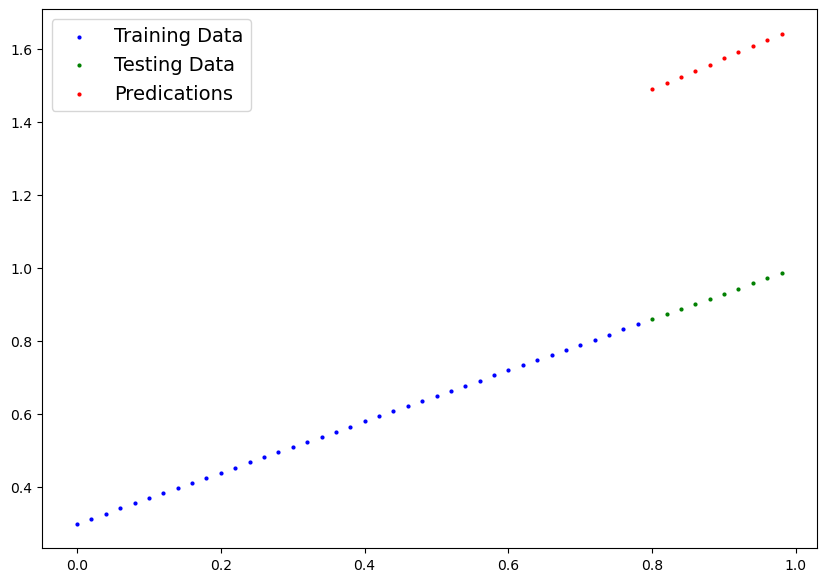

In [15]:
# new predications after some training

with torch.inference_mode():
    y_preds_new = model(X_test)

plot_predications(predications=y_preds_new)